<a href="https://www.kaggle.com/code/drubodevpramanik/character-classification-from-a-facial-image7?scriptVersionId=265747053" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## [1. Import Needed Modules](#import) ##
## [2 Concept for Callback Approach](#concept) ##
## [3. Define function to print text in rgb foreground and background colors](#pc) ##
## [4. Read in csv file and create train, test and valid dataframes](#makedf) ## 
## [5. Trim the trainning set](#Balance) ##
## [6. Create train, test and validation generators](#generators) ## 
## [7. Create a function to show Training Image Samples](#show) ## 
## [8. Create the Model](#model) ## 
## [9. Create a custom Keras callback to continue or halt training](#callback) ## 
## [10. Instantiate custom callback ](#callbacks) ##
## [11. Show video ](#video) ##
## [12. Train the model](#train) ##
## [13. Define a function to plot the training data](#plot) ##
## [14. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [15 Show images in images to predict directory](#showimg) ##
## [16 Define Averaging Predictor Function](#avepred) ##
## [17 Define a function that detects faces in an image and returns a cropped facial image](#cropper) ##
## [18 Demo crop function](#cropdemo) ##
## [19 Save the model](#save) ##

<a id="import"></a>
# <center>Import needed modules</center>

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from IPython.display import YouTubeVideo
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


<a id="concept"></a>
# <center>Custom Callback Concept</center>
This notebook implements a custom callback to adjust the learning rate during training.  
The callback has a parameter dwell. If dwell is set to True, the callback monitors the  
validation loss. It keeps track of the lowest validation loss thus far achieved as you run  
through each epoch and stores this as the lowest loss and also stores the weights for that  
epoch as the best weights. At the end of an epoch the validation loss for that epoch is  
compared with the lowest loss. If the validation loss at the end of the current epoch is  
less than the lowest loss than it becomes the lowest loss and the weights of the current  
epoch become the best weights  
  
If the validation loss at the end of the current epoch is greator than the lowest loss    
this implies you have moved to a location in Nspace(N is the number of trainable parameters    
on the validation cost function surface that is less favorable(higher cost) than the position  
in Nspace defined by the best weights. Therefore why move the models weights to this less  
favorable location? Better to reset the models weights to the best weights, then lower the  
learning rate and run more epochs. The new learning rate is set to new_lr=current_lr * factor  
where factor is a user specified parameter in the instantiation of the callback. By default  
it is set to .04 and by default dwell is set to True.  
  
At the end of training the callback always returns your model with the weights set to the  
best weights. The callback provides a feature where it periodically queries the user to  
either contine and optionally manually specify a new learning rate or halt training.  
During training the calback provides useful information on the percent improvement in the  
validation loss for each epoch. The is useful to decide when to halt training or manually  
specifying a new learning rate.  

<a id="pc"></a>
## <center>Define a function to print text in specified rgb foreground and background colors</center>
### Add some PZAZZ to your printed output with this function  
form of the call is:  print_in_color(txt_msg, fore_tupple, back_tupple where:
* txt_msg is the string to be printed out  
* fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
* back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="makedf"></a>
# <center>Read in csv file and create train, test and validation data frames</center>

In [3]:
def make_dataframes(csv_path):
    df=pd.read_csv(csv_path)
    datasets=df.groupby('data set')
    train_df=datasets.get_group('train')
    test_df=datasets.get_group('test')
    valid_df=datasets.get_group('valid')
    # change the filepaths column to be the full path to an image
    train_df['filepaths']=train_df['filepaths'].apply(lambda x: os.path.join(r'../input/good-guysbad-guys-image-data-set/', x))
    test_df['filepaths']=test_df['filepaths'].apply(lambda x: os.path.join(r'../input/good-guysbad-guys-image-data-set/', x))
    valid_df['filepaths']=valid_df['filepaths'].apply(lambda x: os.path.join(r'../input/good-guysbad-guys-image-data-set/', x))
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())     
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

csv_path=r'../input/good-guysbad-guys-image-data-set/character.csv'
train_df, test_df, valid_df, classes, class_count = make_dataframes(csv_path)

train_df length:  11220   test_df length:  600   valid_df length:  600
number of classes in processed dataset=  2
the maximum files in any class in train_df is  5610   the minimum files in any class in train_df is  5610
average image height=  307   average image width=  263  aspect ratio h/w=  1.167300380228137


In [4]:
img_size=(200,200)
batch_size=30

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [5]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes



train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 11220 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
test batch size:  75   test steps:  8  number of classes :  2


<a id="show"></a>
# <center>Create a function to show example training images</center>

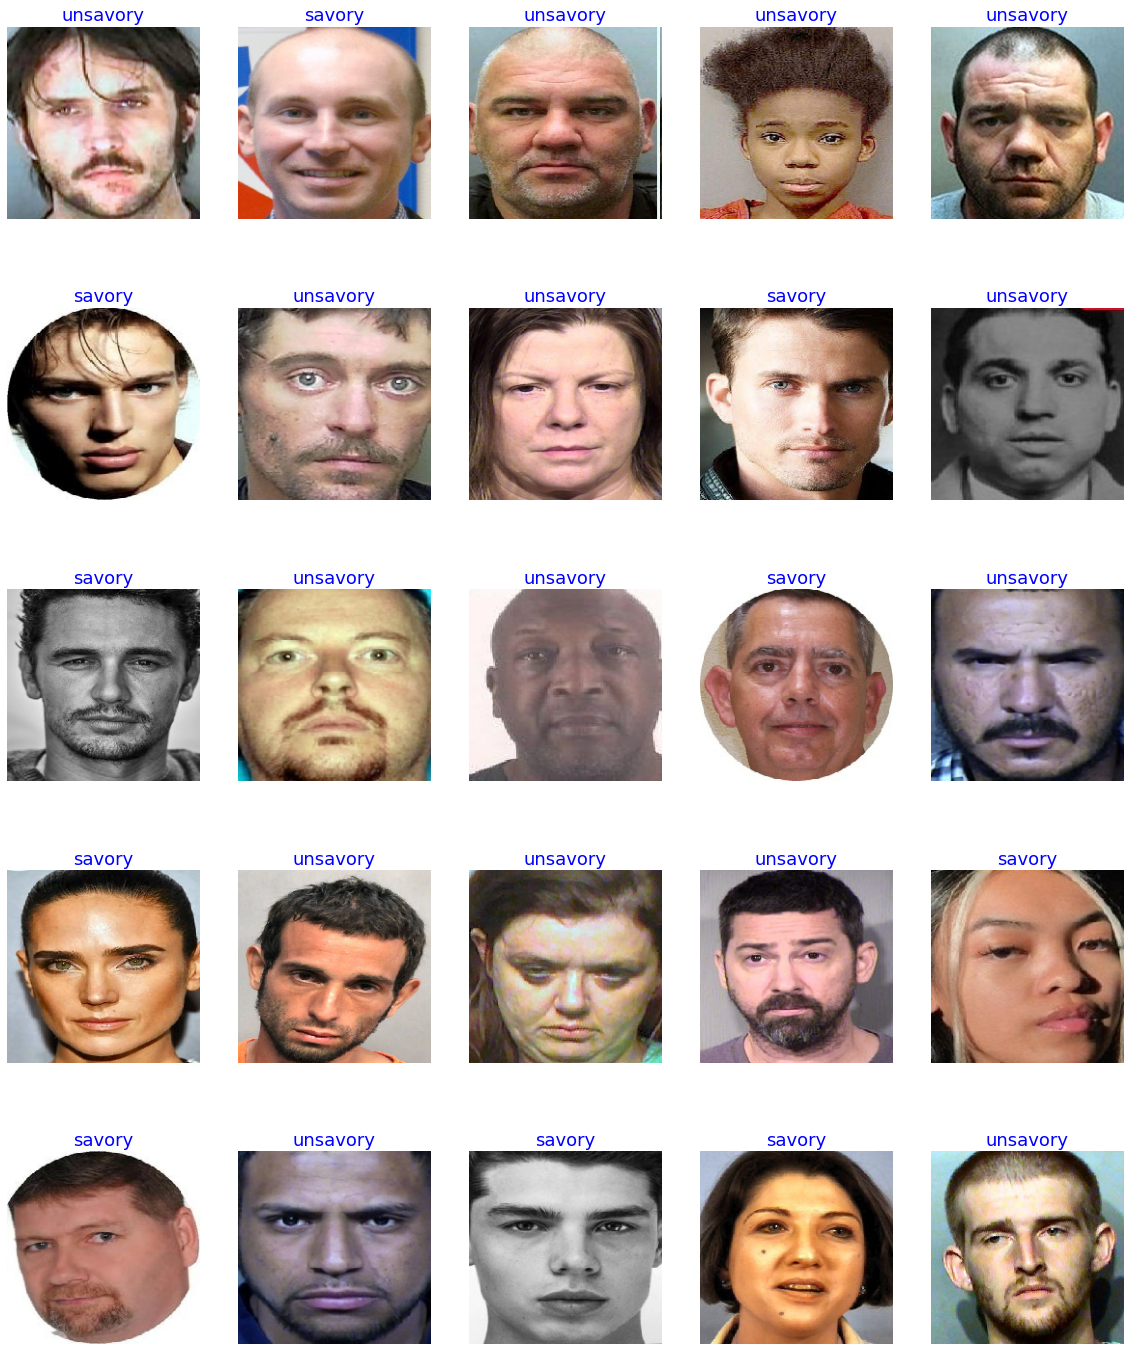

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [7]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

43950080/43941136 [==============================] - 3s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time

class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch, dwell=True, factor=0.4, extra_epochs=3, early_stop_patience=None):
        """
        model: compiled Keras model
        epochs: total epochs to train
        ask_epoch: interval to auto-continue
        dwell: reduce LR if val_loss worsens
        factor: LR reduction factor
        extra_epochs: number of epochs to continue automatically at each query point
        early_stop_patience: stop if no val_loss improvement for these many epochs
        """
        super(LR_ASK, self).__init__()
        self.model_ref = model
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.dwell = dwell
        self.factor = factor
        self.extra_epochs = extra_epochs
        self.early_stop_patience = early_stop_patience

        self.best_weights = self.model_ref.get_weights()
        self.best_epoch = 0
        self.lowest_vloss = np.inf
        self.no_improve_count = 0

    def _get_lr(self):
        opt = self.model.optimizer
        return float(tf.keras.backend.get_value(opt.lr if hasattr(opt, 'lr') else opt.learning_rate))

    def _set_lr(self, new_lr):
        opt = self.model.optimizer
        tf.keras.backend.set_value(opt.lr if hasattr(opt, 'lr') else opt.learning_rate, new_lr)

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')

        # Check improvement
        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            self.no_improve_count = 0
        else:
            self.no_improve_count += 1
            if self.dwell:
                lr = self._get_lr()
                new_lr = lr * self.factor
                self._set_lr(new_lr)
                self.model.set_weights(self.best_weights)

        # Early stopping
        if self.early_stop_patience and self.no_improve_count >= self.early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            self.model.stop_training = True
            return

        # Auto-continue training
        if epoch + 1 == self.ask_epoch:
            self.ask_epoch += self.extra_epochs
            if self.ask_epoch > self.epochs:
                self.ask_epoch = self.epochs

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        print(f"Training finished. Best epoch: {self.best_epoch}, val_loss: {self.lowest_vloss:.4f}")


<a id="callbacks"></a>
# <center>Instantiate custom callback </center>

In [9]:
# Simplified LR_ASK with dwell + early stopping
callback = LR_ASK(
    model=model,
    epochs=4,        # total epochs you want to run
    ask_epoch=2,          # first "query point" (auto-continue after this)
    dwell=True,           # reduce LR if val_loss worsens
    factor=0.5,           # factor to reduce LR
    extra_epochs=3,       # auto-continue this many epochs at each query point
    early_stop_patience=5 # stop if no improvement in val_loss for 5 epochs
)


<a id="video"></a>

## <center><font color=blue>Play The Good, the Bad and the Ugly while training your model</font></center>

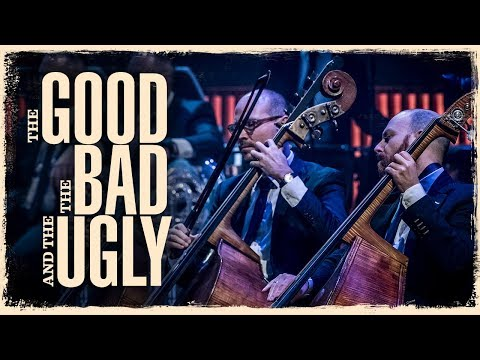

In [10]:
video = YouTubeVideo(id='enuOArEfqGo')
display(video)

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have always found this to be true

In [11]:
history = model.fit(
    x=train_gen,
    epochs=4,
    verbose=1,
    callbacks=[callback],
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0
)


Epoch 1/4
374/374 [==============================] - 152s 357ms/step - loss: 3.7304 - accuracy: 0.9234 - val_loss: 1.7022 - val_accuracy: 0.9750
Epoch 2/4
374/374 [==============================] - 125s 335ms/step - loss: 1.0481 - accuracy: 0.9676 - val_loss: 0.5992 - val_accuracy: 0.9750
Epoch 3/4
374/374 [==============================] - 121s 323ms/step - loss: 0.3934 - accuracy: 0.9818 - val_loss: 0.2986 - val_accuracy: 0.9667
Epoch 4/4
374/374 [==============================] - 126s 335ms/step - loss: 0.2115 - accuracy: 0.9835 - val_loss: 0.2043 - val_accuracy: 0.9650
Training finished. Best epoch: 4, val_loss: 0.2043


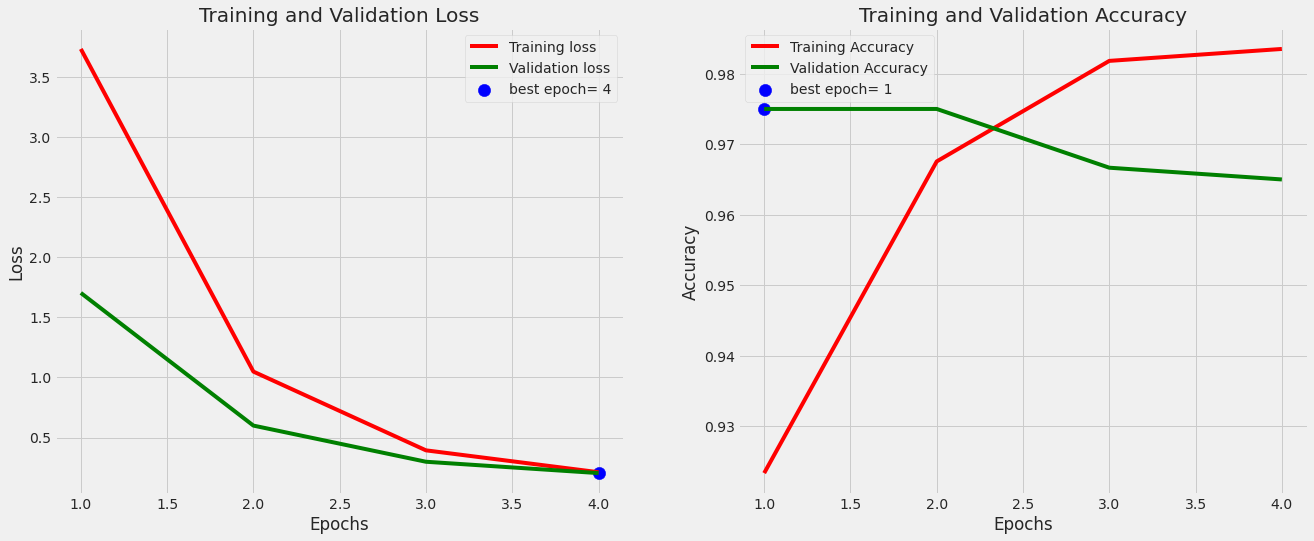

In [12]:
#define a function to plot the training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)


<a> id="result"</a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

8/8 [==============================] - 7s 617ms/step
there were 9 errors in 600 tests for an accuracy of  98.50



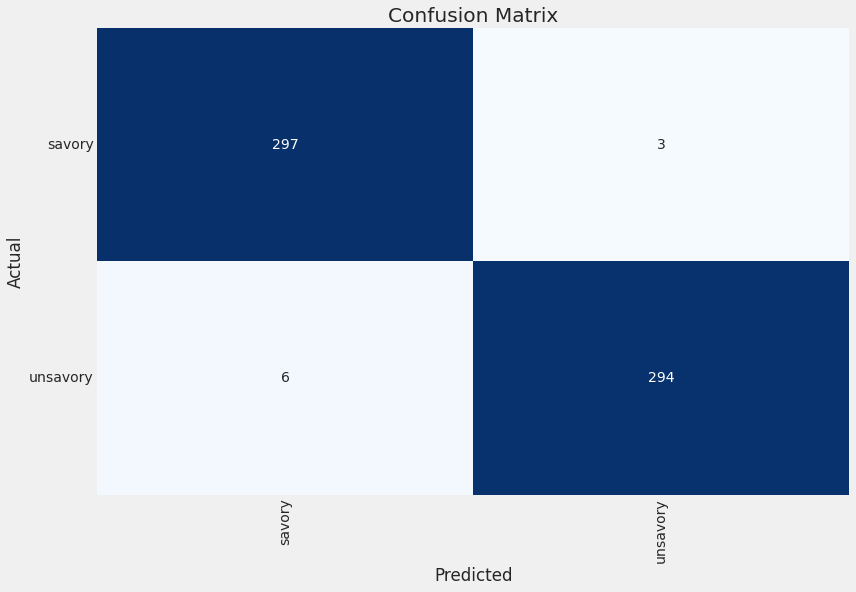

Classification Report:
----------------------
               precision    recall  f1-score   support

      savory     0.9802    0.9900    0.9851       300
    unsavory     0.9899    0.9800    0.9849       300

    accuracy                         0.9850       600
   macro avg     0.9850    0.9850    0.9850       600
weighted avg     0.9850    0.9850    0.9850       600



In [13]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):  
        file=test_gen.filenames[i]        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score =predictor(test_gen)
    
    

In [14]:
if len(error_list) > 0 and len(error_list)<50:    
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))   
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i][0]         
        split=fpath.split('/')          
        f=split[4]+ split[5]
        pred_class=sorted_list[i][1]
        print(f'{f:^30s}{pred_class:^30s}')

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
        savory030.jpg                    unsavory           
        savory076.jpg                    unsavory           
        savory081.jpg                    unsavory           
       unsavory001.jpg                    savory            
       unsavory063.jpg                    savory            
       unsavory089.jpg                    savory            
       unsavory173.jpg                    savory            
       unsavory178.jpg                    savory            
       unsavory179.jpg                    savory            


<a id="showimg"></a>
# <center>Show images from  images to predict </center>

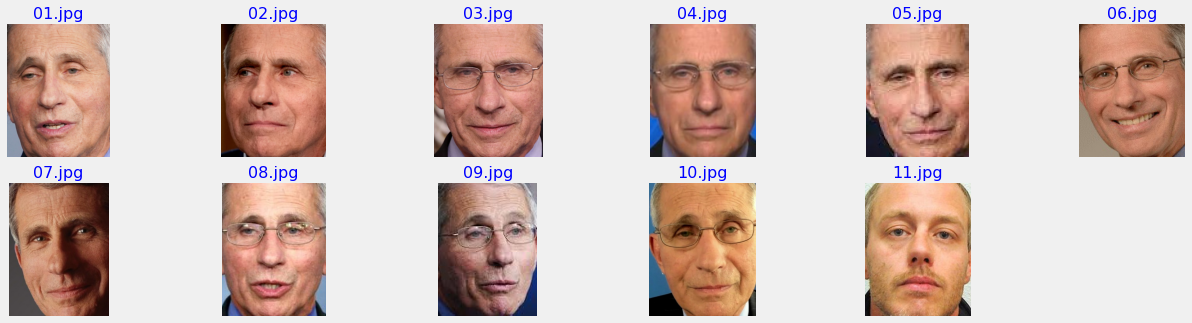

In [15]:

plt.figure(figsize=(20,5))
sdir=r'../input/good-guysbad-guys-image-data-set/images to predict'
flist=sorted(os.listdir(sdir))
for i,f in enumerate(flist):
    fpath=os.path.join(sdir,f)
    img=plt.imread(fpath)
    plt.subplot(2,6,i +1)
    plt.axis('off')
    plt.title(f, color='blue', fontsize=16)
    plt.imshow(img)
plt.show()
    

<a id="avepred"></a>
# <center>Define a function that can average predictions on images</center>

In [16]:
#lets define a useful function that will predict images in a directory. It will have a parameter average.
# If average=False and individual prediction is made on each image and the results are printed out.
#If averaged=True, individual predictions are made on each image. The probabilities for each image are
#then summed. The class prediction of ALL the images is given by the class with the highest summed probability.
# The probabilitty for the class is then the sum of the probabilities  for the selected class divided by the number of images
def ave_predictor(sdir,img_size, average=False):
    img_list=[]
    fname=[]
    class_list=[]
    savory_probs=[]
    unsavory_probs=[]
    prob_list=[]
    flist=sorted(os.listdir(sdir))
    img_count=len(flist)
    for f in flist:
        fpath=os.path.join(sdir,f)
        img=plt.imread(fpath)
        img=cv2.resize(img, (img_size[1], img_size[0]))
        img_list.append(img)
        fname.append(f)
    img_array=np.array(img_list)
    preds=model.predict(img_array, steps=img_count)
    for p in preds:
        index=np.argmax(p)
        klass=classes[index]
        class_list.append(klass)
        savory_probs.append(p[0])
        unsavory_probs.append(p[1])
        prob_list.append(p[index])
    if average == False:
        Fseries=pd.Series(fname, name='file name')
        Lseries=pd.Series(class_list, name='Predicted Class')
        Pseries=pd.Series(prob_list, name='Probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        print(df.head(img_count))
        return df
    else: #average the probabilities
        savory_sum=0
        unsavory_sum=0
        for savory, unsavory in zip(savory_probs, unsavory_probs):
            savory_sum += savory/img_count
            unsavory_sum += unsavory/img_count
        if savory_sum>= unsavory_sum:
            klass='Savory'
            prob=savory_sum
        else:
            klass='Unsavory'
            prob=unsavory_sum
            return klass
    print(f' majority class is {klass} with probability {prob:6.2f}')
        

In [17]:
# call the predictor on the images to predict directory. It has 10 images (01 to 10) of Dr Fauci and 1(11) image of a felon.
#So 10 of the predictions such be savory and 1 should be unsavory
sdir= r'../input/good-guysbad-guys-image-data-set/images to predict'
result=ave_predictor(sdir,img_size, average=False)


   file name Predicted Class  Probability
0     01.jpg          savory     0.987741
1     02.jpg          savory     0.996140
2     03.jpg          savory     0.995433
3     04.jpg          savory     0.912848
4     05.jpg          savory     0.909950
5     06.jpg          savory     0.981300
6     07.jpg          savory     0.996942
7     08.jpg          savory     0.969574
8     09.jpg          savory     0.981069
9     10.jpg          savory     0.997629
10    11.jpg        unsavory     0.910189


### now demonstrate the predictor function with average=True. This function is useful when you want to predict an
### individual's pre-dispositioned genetic character. Rather than rely using the classification from a single image
### it is far more accurate to take several facial images of the individual, place them in a directory then make a
### prediction with average=True. Remember try to use faces with neutral emotions, no classes, no facial tatoos etc
### for best results.
# IMPORTANT:
### This prediction I believe to be that of a genetic pre-disposition toward one class or the other.
### This is NOT a prediction of the true persona of the individual. Impacts of cultural experiences
### can and do alter the effects of genetics to form the final true persona of an individual

In [18]:
# now run the predictor with average=True
result=ave_predictor(sdir,img_size, average=True)

 majority class is Savory with probability   0.89


## Note the probability of the majority class is reduced by the presence of an image of a felon

### The input images you use for predictions should be straight on front images of the face only as that
### is what the model was trained on. If you do not have the ability to crop images below is a function
### that will take in images in a directory and attempt to crop and store them.
### The form of the call is crop_image(sdir, outdir, img_size, ext,snum) where:
* sdir is the full path to the directory containing the image files
* outdir is the full path to where the dropped images will be stored
  if it does not exist the function creates it.
* img_size is either a tupple (height, width) or None. If None images are not resized
  if a tuble images are resized
* ext is a string. If ext=None the cropped images are save in the original file format
  if ext is a valid extension that can be processed by cv2 the cropped images are converted to that format
* snum is either an integr or None. If None the cropped images are stored using the original file name.
  if an integer, files are renamed sequentially starting with the value of snum. This is useful in 2 ways.
  First images downloaded from the internet often have long unyieldy names that are hard to work with.
  Second, assume you already ran the program for 100 files and they were all cropped and are srored with
  image names 1.jpg, 2.jpg ...100.jpg. Now if you remove the images in the sdir with a set of new images
  and run the function with snum=101 your original cropped files will not be over written.


<a id="cropper"></a>
# <center>Define a function that can crop facial images</center>

In [19]:
!pip install mtcnn  # this module is not inherit in the kaggle environment and must be installed
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tqdm import tqdm
import shutil
    
def crop_image(sdir, outdir, img_size, ext,snum):
    detector = MTCNN()    
    def crop(img):
        #y=box[1] h=box[3] x=box[0] w=box[2]
        data=detector.detect_faces(img)
        biggest=0
        if data !=[]:
            for faces in data:
                box=faces['box']            
                # calculate the area in the image
                area = box[3]  * box[2]
                if area>biggest:
                    biggest=area
                    bbox=box 
            bbox[0]= 0 if bbox[0]<0 else bbox[0]
            bbox[1]= 0 if bbox[1]<0 else bbox[1]
            img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]        
            return (True, img) 
        else:
            return False, None    
        
    crop_index= snum
    status=False
    # check is the outdir exists, if not create it
    if os.path.isdir(outdir)==False:
        os.mkdir(outdir)
        print ('created directory ', outdir)
    else: # directory exists check if it has files
        flist=os.listdir(outdir)
        if len(flist) > 0:
            print ('****WARNING**** directory ', outdir, ' contains files')
            print('Enter D to to delete files in  the directory, H to halt execution or C to continue and risk overwriting files')
            ans=input()                        
            if ans =='D' or ans =='d':
                print('you entered ', ans, ' files in ', outdir, 'will be deleted')
                shutil.rmtree(outdir)
                os.mkdir(outdir)
            elif ans == 'H' or ans == 'h':
                print('You entered ', ans, ' execution of function is halted')
                return False
            else:
                print('Execution will continue and files with same file name will be over written')
    flist=sorted(os.listdir(sdir))    
    for f in tqdm(flist):
        name=f
        fpath=os.path.join(sdir,f)
        if os.path.isfile(fpath):
            try:                            
                img=cv2.imread(fpath)            
                cstatus,img=crop(img)                
                if cstatus:
                    if img_size !=None:
                        img=cv2.resize(img, (img_size[1], img_size[0]))                    
                    if snum != None:
                        index=name.rfind('.')
                        fext=f[index:]
                        name=str(crop_index) + fext
                        crop_index +=1                    
                    if ext !=None:
                        index= name.rfind('.')                                          
                        name= name[:index] + '.'  + ext                    
                    # always change the extension on .jfif files because cv2 can not write those files
                    if 'jfif'  in name:                       
                        index=name.rfind('.')
                        name=name[:index] + ".jpg"                        
                    destpath=os.path.join(outdir,name)
                    cv2.imwrite(destpath, img)
                    status=True                    
                else:
                    print('file ', fpath, ' was not cropped, a face was not detected in the image')
            except:
                print('file', fpath, ' was not cropped')
            
    return status

     |████████████████████████████████| 2.3 MB 14.9 MB/s            


<a id="cropdemo"></a>
# <center>Demo crop_image function using images in uncropped test images directory</center>

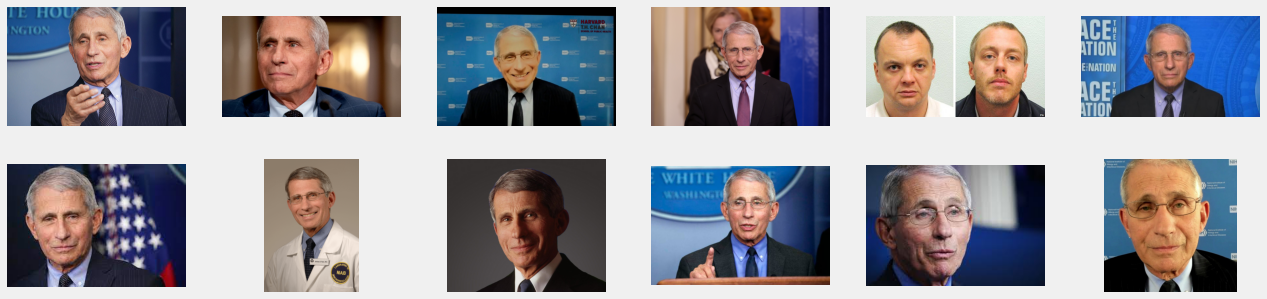

In [20]:
# lets look at the uncropped images in the uncropped test images directory
plt.figure(figsize=(20,5))
sdir=r'../input/good-guysbad-guys-image-data-set/uncropped test images'
flist=sorted(os.listdir(sdir))
for i,f in enumerate(flist):
    fpath=os.path.join(sdir,f)
    img=plt.imread(fpath)
    
    plt.subplot(2,6,i +1)
    plt.axis('off')   
    plt.imshow(img)
plt.show()


In [21]:
# crop the images in the uncropped test images directory
sdir=r'../input/good-guysbad-guys-image-data-set/uncropped test images'
working_dir=r'./'
outdir=os.path.join(working_dir, 'cropped images')
img_size=(300,233) # same size as model was trained on
ext='jpg' # convert cropped images to png format
snum=1 # renumber images starting at 1
status=crop_image(sdir, outdir, img_size, ext,snum)

created directory  ./cropped images


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


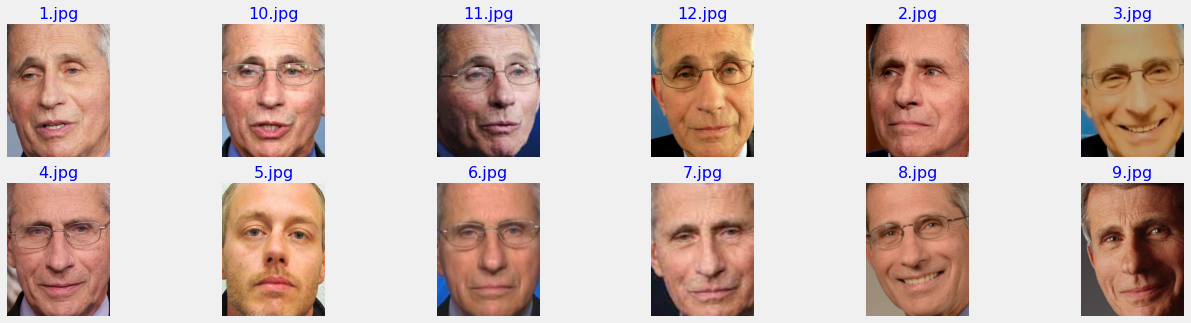

In [22]:
# lets look at the cropped images
plt.figure(figsize=(20,5))
sdir=r'./cropped images'
flist=sorted(os.listdir(sdir))
for i,f in enumerate(flist):
    fpath=os.path.join(sdir,f)
    img=plt.imread(fpath)
    
    plt.subplot(2,6,i +1)
    plt.axis('off')
    plt.title(f, color='blue', fontsize=16)
    plt.imshow(img)
plt.show()
